In [2]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set(style="whitegrid", palette="pastel")

engine = create_engine("sqlite:///../data/db.sqlite")
df = pd.read_sql("SELECT * FROM orders", engine)

In [4]:
print(df.shape)
print(df.info())
print(df.describe())

(5009, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         5009 non-null   int64  
 1   Order ID       5009 non-null   object 
 2   Order Date     5009 non-null   object 
 3   Ship Date      5009 non-null   object 
 4   Ship Mode      5009 non-null   object 
 5   Customer ID    5009 non-null   object 
 6   Customer Name  5009 non-null   object 
 7   Segment        5009 non-null   object 
 8   Country        5009 non-null   object 
 9   City           5009 non-null   object 
 10  State          5009 non-null   object 
 11  Postal Code    5009 non-null   int64  
 12  Region         5009 non-null   object 
 13  Product ID     5009 non-null   object 
 14  Category       5009 non-null   object 
 15  Sub-Category   5009 non-null   object 
 16  Product Name   5009 non-null   object 
 17  Sales          5009 non-null   float64
 1

In [5]:
dx = pd.read_sql(
    'SELECT substr("Order Month",6,2) AS month_num, round(SUM("Sales")) AS Total '
    'FROM orders '
    'GROUP BY month_num '
    'ORDER BY CAST(month_num AS INTEGER) ASC;',
    engine
)
print(dx.to_string(index=False))

month_num    Total
       01  50914.0
       02  36411.0
       03  74808.0
       04  70583.0
       05  85741.0
       06  84545.0
       07  60098.0
       08  81248.0
       09 121114.0
       10  88339.0
       11 173363.0
       12 172698.0


Text(0.5, 0, 'Month')

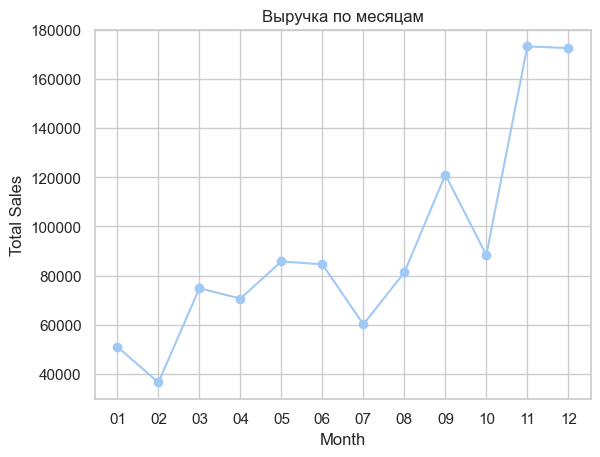

In [6]:
plt.plot(dx["month_num"], dx["Total"],marker="o")
plt.title("Выручка по месяцам")
plt.ylabel("Total Sales")
plt.xlabel("Month")


In [7]:
med = dx["Total"].median()
top3 = dx.nlargest(3, "Total").copy()
top3["Percent"] = ((top3["Total"] / med - 1) * 100).round(1)
print(top3.to_string(index=False))

month_num    Total  Percent
       11 173363.0    109.1
       12 172698.0    108.3
       09 121114.0     46.1


Сезонность выражена: пик в  сентябре, ноябре и декабре (выручка на 50-100 процентов выше медианы). 
В сентябре это можно объяснить началом ученого и рабочего года, а в ноябре и декабре - подготовкой к праздникам.

In [8]:
dy = pd.read_sql(
    """
    SELECT Category, round(SUM("Sales"), 1) AS Total_Sales, round(SUM("Profit")) AS Total_Profit,
    round(100*SUM("Profit")/SUM("Sales"), 1) as Margin
    FROM orders
    GROUP BY Category
    ORDER BY Margin asc;
    """,
    engine
)
print(dy.to_string(index=False))

       Category  Total_Sales  Total_Profit  Margin
      Furniture     373504.7        7569.0     2.0
Office Supplies     345716.5       54789.0    15.8
     Technology     380640.9       70158.0    18.4


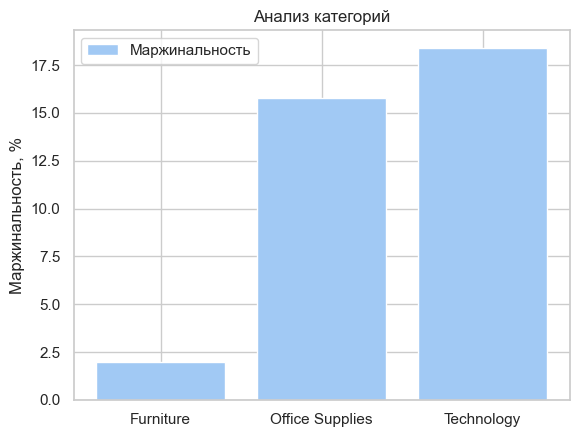

In [9]:
x = dy["Category"]
y = dy["Margin"]
plt.bar(x, y, label='Маржинальность') 
plt.ylabel('Маржинальность, %')
plt.title('Анализ категорий')
plt.legend()
plt.show()

Видим, что продажа товаров категории "Мебель" не приносит должной маржи.

In [10]:
dk = pd.read_sql(
    """
    SELECT "Sub-Category", round(SUM("Profit")) AS Total_Profit FROM orders
    GROUP BY "Sub-Category"
    ORDER BY Total_Profit desc;
    """,
    engine
)
print(dk.head(3).to_string(index=False))
print(dk.tail(3).to_string(index=False))

Sub-Category  Total_Profit
     Copiers       22403.0
      Phones       20939.0
 Accessories       19209.0
Sub-Category  Total_Profit
    Supplies        -754.0
   Bookcases       -1247.0
      Tables      -10997.0


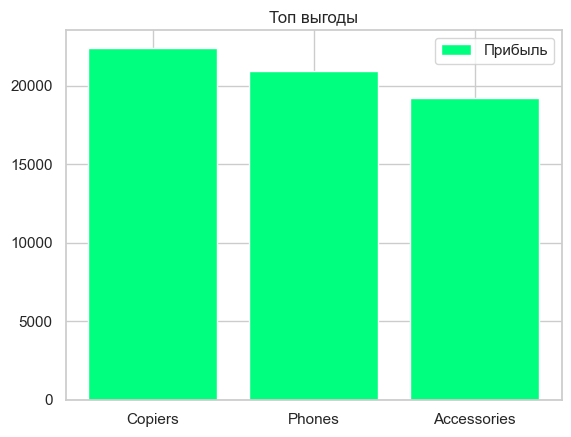

In [16]:
x = dk.head(3)["Sub-Category"]
y = dk.head(3)["Total_Profit"]
plt.bar(x, y, color="SpringGreen", label='Прибыль') 
plt.title('Топ выгоды')
plt.legend()
plt.show()

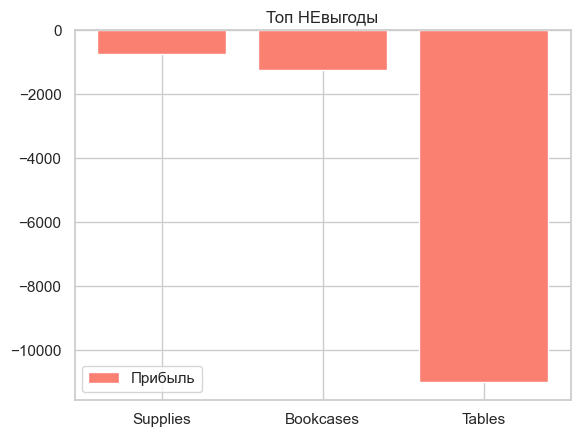

In [17]:
x = dk.tail(3)["Sub-Category"]
y = dk.tail(3)["Total_Profit"]
plt.bar(x, y, color="salmon", label='Прибыль') 
plt.title('Топ НЕвыгоды')
plt.legend()
plt.show()

Самые прибыльные подактегории это: Accessories, Copiers, Phones
Неприбыльными являются -  Supplies, Bookcases, Tables

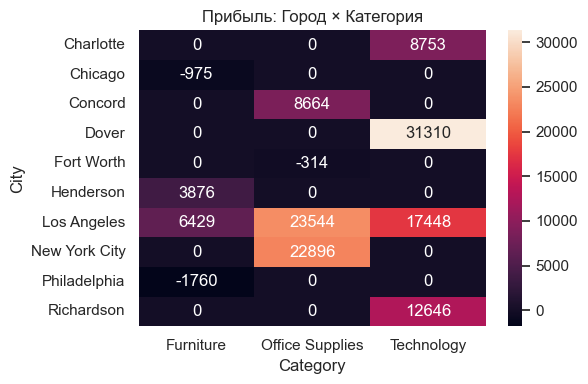

In [18]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent   
SQL_PATH = PROJECT_ROOT / "sql" / "01_city_category_profit.sql"
query = SQL_PATH.read_text(encoding="utf-8")
df_sql = pd.read_sql(query, engine)
mat = df_sql.pivot_table(
    index="City", columns="Category",
    values="Total_Profit", aggfunc="sum", fill_value=0
)
mat = df_sql.pivot_table(index="City", columns="Category", values="Total_Profit", aggfunc="sum", fill_value=0)
plt.figure(figsize=(6,4))
sns.heatmap(mat, annot=True, fmt=".0f")
plt.title("Прибыль: Город × Категория")
plt.tight_layout()
plt.show()

Видим, что New York и Los Angeles присонят самую большую прибыль, а вот Philadelphia приносит отрицательную прибыль.

In [29]:
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent  
SQL_PATH = PROJECT_ROOT / "sql" / "02_ABC.sql"
query = SQL_PATH.read_text(encoding="utf-8")
df_sql = pd.read_sql(query, engine)
print(df_sql.to_string(index=False))

Sub-Category  Total_Sale  Percent
      Chairs    166703.7     15.2
      Phones    162431.8     14.8
     Storage    107383.0      9.8
      Tables    104410.7      9.5
     Binders    103534.4      9.4
    Machines     75844.4      6.9
 Accessories     72235.7      6.6
     Copiers     70129.0      6.4
   Bookcases     54547.5      5.0
  Appliances     52911.2      4.8
 Furnishings     47842.9      4.3
       Paper     37897.9      3.4
         Art     14966.6      1.4
    Supplies     13027.9      1.2
   Envelopes      9254.8      0.8
      Labels      5133.9      0.5
   Fasteners      1606.7      0.1


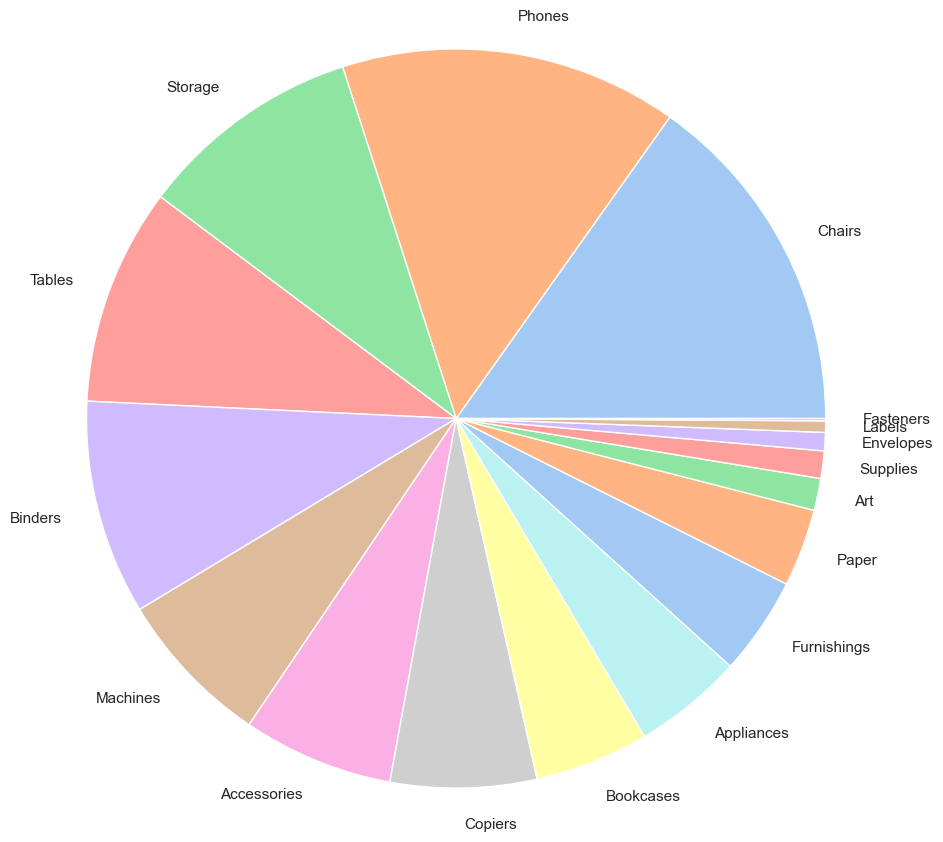

In [41]:
data = df_sql["Percent"]
labels = df_sql["Sub-Category"]
plt.pie (data, labels=labels, radius = 2.5)
plt.show()

На основе графика можем сгруппировать подкатегории по степени влияния на продажи.
Категория A: Chairs, Phones, Storage, Tables, Binders, Machines, Accessories, Copiers, Bookcases - 80% продаж
Категория B: Appliances, Furnishings, Paper, Art - 15% продаж
Категория C: Supplies, Envelopes, Labels, Fasteners - 5% продаж

In [62]:
from pathlib import Path
params = {"date_from": "2015-01-01", "date_to": "2016-12-31", "cat": "Furniture"}
PROJECT_ROOT = Path.cwd().parent  
SQL_PATH = PROJECT_ROOT / "sql" / "03_KPI.sql"
query = SQL_PATH.read_text(encoding="utf-8")
df_sql = pd.read_sql(query, engine, params=params)
print(df_sql.to_string(index=False))

 tot  tot_los  loss_rate_pct
 545      177          32.48
